In [1]:
import xarray as xr
import zarr
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
#import data_module as dm
#import train_callbacks as tc
import dask
import torch

with open("../config.yaml") as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
        
def find_nearest_idx(
    arr1: np.ndarray,
    arr2: np.ndarray,
    val1: float,
    val2: float,
) -> int:
    """Find first nearest index for a given tolerance for two arrays and 2 values

    :param arr1: first array
    :param arr2: second arrat
    :param val1: value to find in first array
    :param val2: value to find in second array
    :return: index as int
    """
    return (np.abs(arr1 - val1) + np.abs(arr2 - val2)).argmin()


def transform(x, mean, std):
    x_norm = (x - mean) / (std + 1e-5)
    return x_norm


def invtransform(x, mean, std):
    x_norm = (x * (std + 1e-5)) + mean
    return x_norm

#ds = zarr.open("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
#ds["data"][0]

In [2]:
xr.open_zarr("/scratch/daep/ecland_i6aj_2017_2022_1h.zarr").data

<xarray.DataArray 'data' (time: 51840, x: 164695, variable: 34)>
dask.array<open_dataset-3ad048edcfde5eee7024d2e65bffade4data, shape=(51840, 164695, 34), dtype=float32, chunksize=(24, 164695, 34), chunktype=numpy.ndarray>
Coordinates:
    lat       (x) float32 dask.array<chunksize=(164695,), meta=np.ndarray>
    lon       (x) float32 dask.array<chunksize=(164695,), meta=np.ndarray>
  * time      (time) datetime64[ns] 2017-01-01 ... 2022-11-30T23:00:00
  * variable  (variable) object 'met_ctpf' 'met_lwdown' ... 'log10_sd'
  * x         (x) int32 2465 2764 2898 2899 2911 ... 603441 603443 604077 604078
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

In [9]:
51840. / 36.

1440.0

In [5]:
24*24

576

In [5]:
# dataset = dm.EcDataset(start_yr=2022, end_yr=2022, x_idxs=(38582, 38582+1))
dataset = dm.EcDataset(start_yr=2022, end_yr=2022, x_idxs=(500, 500+1), path="/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")
# dataset = dm.EcDataset(start_yr=2022, end_yr=2022, path="/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")

In [8]:
dataset.dynamic_index

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [3]:
dataset.ds_ecland.lat[500], dataset.ds_ecland.lon[500] 

(48.007484, 5.183246)

In [29]:
#ds = xr.open_zarr("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
ds = xr.open_zarr("/ec/res4/hpcperm/daep/ecland_i8ki_o200_2010_2022_1hr.zarr")
ds

<xarray.Dataset> Size: 651GB
Dimensions:                (x: 47892, clim_variable: 22, time: 113208,
                            variable: 30)
Coordinates:
  * clim_variable          (clim_variable) object 176B 'clim_cell_area' ... '...
    lat                    (x) float32 192kB dask.array<chunksize=(47892,), meta=np.ndarray>
    lon                    (x) float32 192kB dask.array<chunksize=(47892,), meta=np.ndarray>
  * time                   (time) datetime64[ns] 906kB 2010-01-01 ... 2022-11...
  * variable               (variable) object 240B 'met_ctpf' ... 'slhf'
  * x                      (x) int32 192kB 713 714 715 ... 167198 167199 167200
Data variables:
    clim_data              (x, clim_variable) float32 4MB dask.array<chunksize=(47892, 22), meta=np.ndarray>
    clim_means             (clim_variable) float32 88B dask.array<chunksize=(22,), meta=np.ndarray>
    clim_stdevs            (clim_variable) float32 88B dask.array<chunksize=(22,), meta=np.ndarray>
    data                   (time, x, variable) float32 651GB dask.array<chunksize=(24, 47892, 30), meta=np.ndarray>
    data_means             (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>
    data_stdevs            (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>
    firstdiff_means        (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>
    firstdiff_stdevs       (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>
    norm_firstdiff_means   (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>
    norm_firstdiff_stdevs  (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>

In [30]:
idx = find_nearest_idx(ds.lat.values, ds.lon.values, 48.007484, 5.18324)
print(ds.lat.values[idx], ds.lon.values[idx])
idx

47.86512 5.5102043


9973

In [21]:
da=xr.open_zarr("/ec/res4/scratch/daep/ec_training_db_out_O200/ecland3_i8ki_2010_2010_1H.zarr")#.sel(time="2010-02")
da2=xr.open_zarr("/ec/res4/scratch/daep/ec_training_db_out_O200/i8ki_20100201.zarr")

#da.sshf.values

def deacc_flux(da):
    flux_acc = da.values
    flux = np.zeros_like(flux_acc)
    flux[1::24] = flux_acc[1::24]
    for i in range(2, 24):
        #print(i)
        flux[i::24] = flux_acc[i::24] - flux_acc[i-1::24]
    #flux[23::24] = flux_acc[23::24] - flux_acc[22::24]
    flux[24::24] = np.mean([flux[25::24], flux[23::24][:-1]], axis=0)
    return flux
    
da2["sshf"][:] = deacc_flux(da2.sshf)

In [31]:
list(da2.data_vars)

['aco2gpp',
 'asn',
 'clim_CLAKE',
 'clim_Ctype',
 'clim_LDEPTH',
 'clim_cell_area',
 'clim_cu',
 'clim_cvh',
 'clim_cvl',
 'clim_geopot',
 'clim_glm',
 'clim_landsea',
 'clim_lz0h',
 'clim_sdfor',
 'clim_sdor',
 'clim_seaice',
 'clim_sotype',
 'clim_sst',
 'clim_theta_cap',
 'clim_theta_pwp',
 'clim_tvh',
 'clim_tvl',
 'clim_veg_covh',
 'clim_veg_covl',
 'clim_veg_rsminh',
 'clim_veg_rsminl',
 'clim_veg_z0mh',
 'clim_veg_z0ml',
 'clim_z0m',
 'd2m',
 'dis',
 'e',
 'es',
 'fal',
 'fldsto',
 'lai_hv',
 'lai_lv',
 'lwcs_l1',
 'lwcs_l2',
 'lwcs_l3',
 'lwcs_l4',
 'lwcs_l5',
 'rsn',
 'rsn_l1',
 'rsn_l2',
 'rsn_l3',
 'rsn_l4',
 'rsn_l5',
 'sd',
 'sd_l1',
 'sd_l2',
 'sd_l3',
 'sd_l4',
 'sd_l5',
 'skt',
 'slhf',
 'snowc',
 'sro',
 'sshf',
 'ssro',
 'stl1',
 'stl2',
 'stl3',
 'stl4',
 'swvl1',
 'swvl2',
 'swvl3',
 'swvl4',
 't2m',
 'tsn',
 'tsn_l1',
 'tsn_l2',
 'tsn_l3',
 'tsn_l4',
 'tsn_l5']

In [67]:
flux_acc = ds.isel(x=idx).sel(time="2010-07", variable="sshf").data.compute()
flux_acc

<xarray.DataArray 'data' (time: 744)> Size: 3kB
array([   -6573.  ,    41526.  ,    73246.5 ,   100160.  ,   123112.  ,
         136977.  ,   185263.  ,   191953.  ,   148393.  ,    99336.  ,
         -55348.  ,  -255434.  ,  -455225.  ,  -624014.  ,  -739033.  ,
        -793764.  ,  -768418.  ,  -690160.  ,  -595417.  ,  -437903.  ,
        -406690.  ,  -385095.  ,  -363805.  ,  -343662.  ,  -325386.  ,
          17369.25,    33794.5 ,    49411.  ,    64815.  ,    76956.  ,
         100276.  ,    52532.  ,   -46856.  ,  -176639.  ,  -315303.  ,
        -480117.  ,  -570473.  ,  -650836.  ,  -667312.  ,  -632466.  ,
        -568912.  ,  -497317.  ,  -333106.  ,  -226014.  ,  -215407.  ,
        -205785.  ,  -194830.  ,  -179062.  ,  -161984.  ,    13983.25,
          27632.5 ,    43150.  ,    59820.  ,    74614.  ,   115933.  ,
         125094.  ,    65676.  ,   -14819.  ,  -190885.  ,  -480054.  ,
        -809821.  , -1090038.  , -1353462.  , -1558795.  , -1685924.  ,
       -1625553.  , -1561067.  , -1425985.  , -1333213.  , -1243894.  ,
       -1157321.  , -1073212.  ,  -988546.  ,    78046.  ,   148622.5 ,
         202156.  ,   249398.  ,   273328.  ,   254473.  ,   162161.  ,
         -26890.  ,  -239476.  ,  -602576.  ,  -993283.  , -1426942.  ,
       -1794736.  , -2075812.  , -2281925.  , -2406586.  , -2417710.  ,
       -2297383.  , -2103278.  , -1926356.  , -1803972.  , -1719900.  ,
       -1662635.  , -1619250.  ,    41130.  ,    75389.25,   108363.  ,
...
       -2014218.  , -1998268.  , -1985305.  , -1974452.  ,    10895.  ,
          19340.  ,    26914.5 ,    32979.  ,    38814.  ,    77003.  ,
         151682.  ,   194838.  ,   238869.  ,   261055.  ,   241004.  ,
         202018.  ,   -44305.  ,  -342083.  ,  -541969.  ,  -685910.  ,
        -704040.  ,  -611708.  ,  -543485.  ,  -532720.  ,  -521418.  ,
        -507507.  ,  -490279.  ,  -472869.  ,    26938.  ,    72963.  ,
         128226.  ,   197697.  ,   273176.  ,   317005.  ,   282113.  ,
         169601.  ,  -161882.  ,  -478696.  ,  -910607.  , -1259513.  ,
       -1584035.  , -1782225.  , -1933825.  , -2010529.  , -2009350.  ,
       -1894661.  , -1762381.  , -1641364.  , -1583610.  , -1561006.  ,
       -1532354.  , -1501771.  ,    28064.5 ,    54571.5 ,    78504.5 ,
          92817.  ,   100595.  ,   114075.  ,     8546.  ,  -180834.  ,
        -498257.  ,  -915652.  , -1473411.  , -1973125.  , -2293640.  ,
       -2570621.  , -2730077.  , -2821349.  , -2844967.  , -2789444.  ,
       -2738465.  , -2718808.  , -2701452.  , -2684369.  , -2667358.  ,
       -2651031.  ,    16533.  ,    32824.  ,    48203.  ,    62088.  ,
          73022.  ,    91044.  ,    34876.  ,  -144761.  ,  -418391.  ,
        -770856.  , -1165036.  , -1578831.  , -1954910.  , -2268027.  ,
       -2469808.  , -2532523.  , -2465794.  , -2376372.  , -2291815.  ,
       -2255360.  , -2229402.  , -2201142.  , -2171286.  ], dtype=float32)
Coordinates:
    lat       float32 4B 47.87
    lon       float32 4B 5.51
  * time      (time) datetime64[ns] 6kB 2010-07-01 ... 2010-07-31T23:00:00
    variable  <U4 16B 'sshf'
    x         int32 4B 18979
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

In [70]:
flux_acc2 = flux_acc.resample(time="1h").mean()
np.all(flux_acc2 == flux_acc)

<xarray.DataArray 'data' ()> Size: 1B
array(True)
Coordinates:
    lat       float32 4B 47.87
    lon       float32 4B 5.51
    variable  <U4 16B 'sshf'
    x         int32 4B 18979

In [50]:
flux_acc.resample(time="6h").mean()

/perm/daep/conda/envs/ml-tt/lib/python3.10/site-packages/xarray/core/groupby.py:532: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


<xarray.DataArray 'data' (time: 124)> Size: 496B
dask.array<groupby_nanmean, shape=(124,), dtype=float32, chunksize=(4,), chunktype=numpy.ndarray>
Coordinates:
    lat       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lon       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    variable  <U4 16B 'sshf'
    x         int32 4B 18979
  * time      (time) datetime64[ns] 992B 2010-07-01 ... 2010-07-31T18:00:00
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

In [59]:
flux_acc = ds.isel(x=slice(idx, idx+5)).sel(time="2010-07", variable="sshf").data
flux2=np.diff(flux_acc, n=1, axis=0, append=flux_acc[[-1], :])
flux2[0::24] = flux_acc[1::24]

In [66]:
flux_acc = ds.isel(x=idx).sel(time="2010-07", variable="sshf").data.compute()
flux_acc

<xarray.DataArray 'data' (time: 744)> Size: 3kB
array([   -6573.  ,    41526.  ,    73246.5 ,   100160.  ,   123112.  ,
         136977.  ,   185263.  ,   191953.  ,   148393.  ,    99336.  ,
         -55348.  ,  -255434.  ,  -455225.  ,  -624014.  ,  -739033.  ,
        -793764.  ,  -768418.  ,  -690160.  ,  -595417.  ,  -437903.  ,
        -406690.  ,  -385095.  ,  -363805.  ,  -343662.  ,  -325386.  ,
          17369.25,    33794.5 ,    49411.  ,    64815.  ,    76956.  ,
         100276.  ,    52532.  ,   -46856.  ,  -176639.  ,  -315303.  ,
        -480117.  ,  -570473.  ,  -650836.  ,  -667312.  ,  -632466.  ,
        -568912.  ,  -497317.  ,  -333106.  ,  -226014.  ,  -215407.  ,
        -205785.  ,  -194830.  ,  -179062.  ,  -161984.  ,    13983.25,
          27632.5 ,    43150.  ,    59820.  ,    74614.  ,   115933.  ,
         125094.  ,    65676.  ,   -14819.  ,  -190885.  ,  -480054.  ,
        -809821.  , -1090038.  , -1353462.  , -1558795.  , -1685924.  ,
       -1625553.  , -1561067.  , -1425985.  , -1333213.  , -1243894.  ,
       -1157321.  , -1073212.  ,  -988546.  ,    78046.  ,   148622.5 ,
         202156.  ,   249398.  ,   273328.  ,   254473.  ,   162161.  ,
         -26890.  ,  -239476.  ,  -602576.  ,  -993283.  , -1426942.  ,
       -1794736.  , -2075812.  , -2281925.  , -2406586.  , -2417710.  ,
       -2297383.  , -2103278.  , -1926356.  , -1803972.  , -1719900.  ,
       -1662635.  , -1619250.  ,    41130.  ,    75389.25,   108363.  ,
...
       -2014218.  , -1998268.  , -1985305.  , -1974452.  ,    10895.  ,
          19340.  ,    26914.5 ,    32979.  ,    38814.  ,    77003.  ,
         151682.  ,   194838.  ,   238869.  ,   261055.  ,   241004.  ,
         202018.  ,   -44305.  ,  -342083.  ,  -541969.  ,  -685910.  ,
        -704040.  ,  -611708.  ,  -543485.  ,  -532720.  ,  -521418.  ,
        -507507.  ,  -490279.  ,  -472869.  ,    26938.  ,    72963.  ,
         128226.  ,   197697.  ,   273176.  ,   317005.  ,   282113.  ,
         169601.  ,  -161882.  ,  -478696.  ,  -910607.  , -1259513.  ,
       -1584035.  , -1782225.  , -1933825.  , -2010529.  , -2009350.  ,
       -1894661.  , -1762381.  , -1641364.  , -1583610.  , -1561006.  ,
       -1532354.  , -1501771.  ,    28064.5 ,    54571.5 ,    78504.5 ,
          92817.  ,   100595.  ,   114075.  ,     8546.  ,  -180834.  ,
        -498257.  ,  -915652.  , -1473411.  , -1973125.  , -2293640.  ,
       -2570621.  , -2730077.  , -2821349.  , -2844967.  , -2789444.  ,
       -2738465.  , -2718808.  , -2701452.  , -2684369.  , -2667358.  ,
       -2651031.  ,    16533.  ,    32824.  ,    48203.  ,    62088.  ,
          73022.  ,    91044.  ,    34876.  ,  -144761.  ,  -418391.  ,
        -770856.  , -1165036.  , -1578831.  , -1954910.  , -2268027.  ,
       -2469808.  , -2532523.  , -2465794.  , -2376372.  , -2291815.  ,
       -2255360.  , -2229402.  , -2201142.  , -2171286.  ], dtype=float32)
Coordinates:
    lat       float32 4B 47.87
    lon       float32 4B 5.51
  * time      (time) datetime64[ns] 6kB 2010-07-01 ... 2010-07-31T23:00:00
    variable  <U4 16B 'sshf'
    x         int32 4B 18979
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

In [64]:
flux_acc2 = flux_acc.resample(time="1h").mean()


KeyboardInterrupt



In [46]:
flux_acc = ds.isel(x=idx).sel(time="2010-07", variable="sshf").data.values
flux2=np.diff(flux_acc, n=1, append=flux_acc[-1])
flux2[0::24] = flux_acc[1::24]

flux=np.zeros_like(flux_acc)
flux[1::24] = flux_acc[1::24]
for i in range(2, 24):
    #print(i)
    flux[i::24] = flux_acc[i::24] - flux_acc[i-1::24]
#flux[23::24] = flux_acc[23::24] - flux_acc[22::24]
flux[24::24] = np.mean([flux[25::24], flux[23::24][:-1]], axis=0)

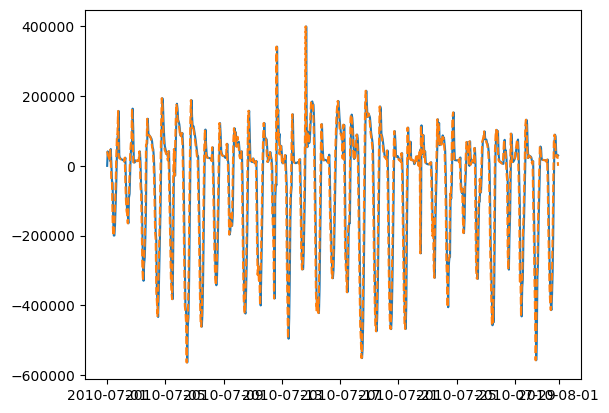

In [48]:
#plt.plot(ds.isel(x=idx).sel(time="2010-07", variable="sshf").time.values,
#         flux_acc)

plt.plot(ds.isel(x=idx).sel(time="2010-07", variable="sshf").time.values,
         flux)

plt.plot(ds.isel(x=idx).sel(time="2010-07", variable="sshf").time.values,
         flux2, '--')

In [24]:
np.mean([flux[25::24], flux[23::24][:-1]], axis=0)

array([ 18756.125,  14875.625,  81077.5  ,  49197.5  , 102442.625,
        95950.375,  22533.875,  28335.375,  66881.75 ,  15911.125,
        43155.25 ,  32424.625,   8425.75 , 148476.   ,  16724.375,
       116168.   ,  22589.5  , 144560.12 ,  47568.875,  23577.25 ,
        15641.75 ,   5030.   ,  75702.875,  15753.   ,  16296.625,
        76180.875,  11929.   ,  22083.   ,  28358.25 ,  16772.   ],
      dtype=float32)

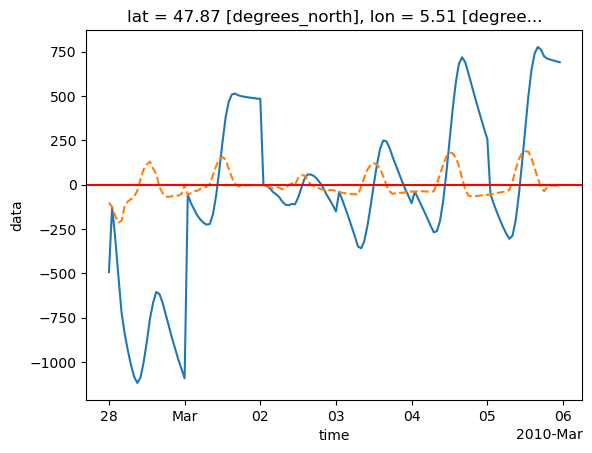

In [25]:
(ds.isel(x=idx).sel(time=slice("2010-02-28", "2010-03-05"), variable="sshf")/(3600*1)*-1).data.plot()
#plt.plot(ds.sel(time=slice("2010-01-01 00:00", "2010-01-05 00:00")).time.values, flux2[:24*4+1])
#plt.plot(ds.sel(time="2010-02").time.values, flux[:]/(3600*1)*-1)
da.sel(time=slice("2010-02-28", "2010-03-05"), variable="sshf").isel(x=idx).data.plot(linestyle='--')
#(da2.isel(x=idx).sshf/(3600*1)*-1).plot()
plt.axhline(y=0.0, color='r', linestyle='-')

In [ ]:
(ds.isel(x=idx).sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00"), variable="sshf").data/(3600*1)*-1).plot()
#plt.plot(ds.sel(time=slice("2010-01-01 00:00", "2010-01-05 00:00")).time.values, flux2[:24*4+1])
plt.plot(ds.sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00")).time.values, flux[:24*8+1]/(3600*1)*-1)
(da.isel(x=idx).sel(variable="sshf").sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00")).sshf/(3600*1)*-1).plot()
plt.axhline(y=0.0, color='r', linestyle='--')

TypeError: No numeric data to plot.

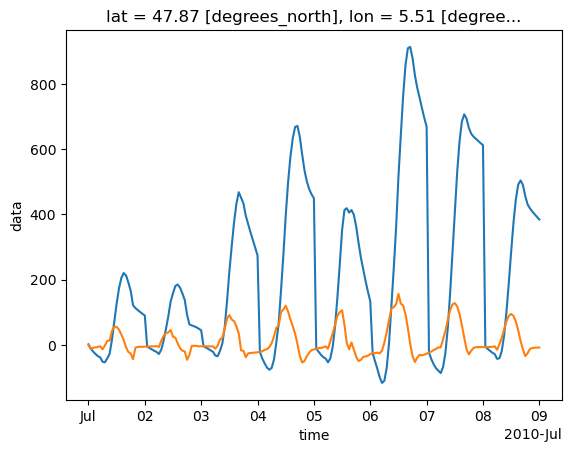

In [26]:
(ds.isel(x=idx).sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00"), variable="sshf").data/(3600*1)*-1).plot()
#plt.plot(ds.sel(time=slice("2010-01-01 00:00", "2010-01-05 00:00")).time.values, flux2[:24*4+1])
plt.plot(ds.sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00")).time.values, flux[:24*8+1]/(3600*1)*-1)
(da2.isel(x=idx).sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00")).sshf/(3600*1)*-1).plot()
plt.axhline(y=0.0, color='r', linestyle='--')

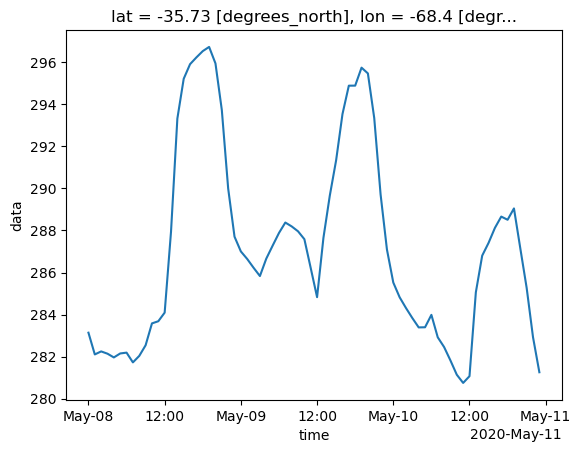

In [27]:
ds.isel(x=42996).sel(time=slice("2020-05-08", "2020-05-10"), variable="t2m").data.plot()

In [132]:
ds.isel(x=idx).sel(time="2020-01", variable="slhf").data.shape

(124,)

In [133]:
np.arange(124)[0::4]

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108, 112, 116, 120])

In [134]:
flux_acc = ds.isel(x=idx).sel(time="2020-07", variable="sshf").data.values
flux=np.zeros(123)

#flux[0::4] = flux_acc[0::4]
flux[0::4] = flux_acc[1::4] - flux_acc[0::4]
flux[1::4] = flux_acc[2::4] - flux_acc[1::4]
flux[2::4] = flux_acc[3::4] - flux_acc[2::4]
flux[3::4] = flux_acc[4::4] - flux_acc[6::4]
#flux[3::4] = flux_acc[4::4] - flux_acc[3::4]

In [135]:
flux_acc = ds.isel(x=idx).sel(time="2020-07", variable="sshf").data.values
flux2=np.diff(flux_acc, n=1)

#flux2[0::4] = flux_acc[0::4]
#flux[1::4] = flux_acc[1::4] - flux_acc[0::4]
#flux[2::4] = flux_acc[2::4] - flux_acc[1::4]
#flux[3::4] = flux_acc[3::4] - flux_acc[2::4]

ValueError: x and y must have same first dimension, but have shapes (72,) and (12,)

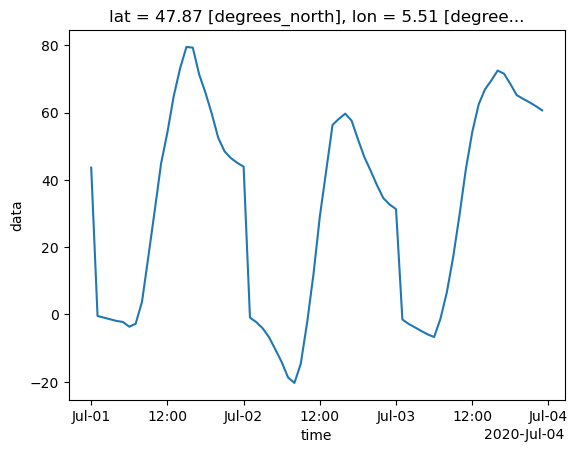

In [28]:
(ds.isel(x=idx).sel(time=slice("2020-07-01", "2020-07-03"), variable="sshf").data/(3600*6)*-1).plot(label="open-loop")
plt.plot(ds.sel(time=slice("2020-07-01", "2020-07-03")).time.values, flux[:4*3]/(3600*6)*-1, label="open-loop de-accumulated")
plt.plot(ds.sel(time=slice("2020-07-01", "2020-07-03")).time.values, flux2[:4*3]/(3600*6)*-1, label="open-loop de-accumulated")
plt.legend()

In [139]:
ds.time.values

array(['2010-02-01T00:00:00.000000000', '2010-02-01T06:00:00.000000000',
       '2010-02-01T12:00:00.000000000', ...,
       '2022-11-30T06:00:00.000000000', '2022-11-30T12:00:00.000000000',
       '2022-11-30T18:00:00.000000000'], dtype='datetime64[ns]')

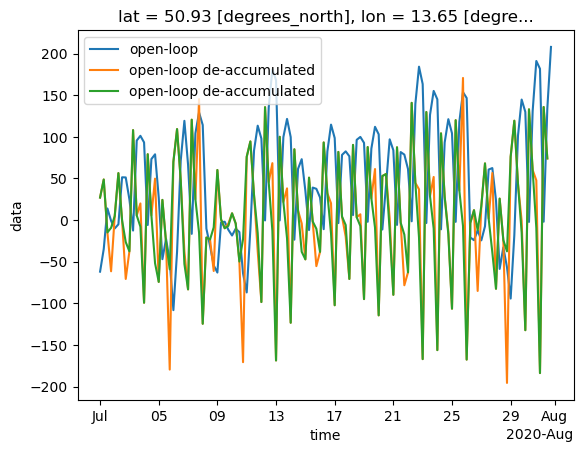

In [138]:
(ds.isel(x=idx).sel(time="2020-07", variable="sshf").data/(3600*6)*-1).plot(label="open-loop")
plt.plot(ds.sel(time="2020-07").time.values[:-1], flux[:]/(3600*6)*-1, label="open-loop de-accumulated")
plt.plot(ds.sel(time="2020-07").time.values[:-1], flux2[:]/(3600*6)*-1, label="open-loop de-accumulated")
plt.legend()

In [106]:
first_diff = ds.data.diff(dim="time")
mus_firstdiff = first_diff.mean(dim=("time", "x")).compute()
stds_firstdiff = first_diff.std(dim=("time", "x")).compute()
mus_firstdiff

<xarray.DataArray 'data' (variable: 30)> Size: 120B
array([ 1.1162232e-06,  1.3758690e-03,  2.0887271e-02,  2.4786832e-08,
       -3.9536065e-11, -1.4714831e-03,  1.4872111e-09,  2.5367574e-04,
       -2.7878968e-05, -6.4790888e-06,  2.0899078e-07,  1.0403950e-06,
        1.8386089e-04,  7.1670959e+01, -2.0612911e-03, -1.2486890e-06,
        3.6287110e-04, -1.6552709e-03, -4.3772239e-09, -6.2628254e-09,
        1.6013796e-04,  1.9426503e-04,  3.2401795e-04, -7.5599104e-07,
        3.7401659e-08, -1.1009563e-06,  2.9975441e-04,  1.7797691e-04,
        4.8517483e-01, -1.7034060e+01], dtype=float32)
Coordinates:
  * variable  (variable) object 240B 'met_ctpf' 'met_lwdown' ... 'sshf' 'slhf'

In [30]:
(stds_firstdiff/(ds.data_stdevs+1e-5)).compute()

<xarray.DataArray (variable: 30)> Size: 120B
array([8.5597825e-01, 2.3779385e-01, 2.1496968e-02, 1.2636486e-01,
       6.2359262e-01, 1.1059271e+00, 8.4493643e-01, 1.8103145e-01,
       4.9127263e-01, 5.1590425e-01, 8.0265431e-03, 7.6786629e-03,
       1.4182447e-01, 1.1928137e-01, 1.3556583e-01, 3.0183286e-04,
       3.5703230e-01, 7.8410715e-02, 4.0551847e-01, 3.8227159e-01,
       1.9901708e-01, 4.1306343e-02, 5.7829935e-03, 7.2182857e-02,
       2.5501577e-02, 5.3810431e-03, 2.3832750e-01, 1.7928387e-01,
       6.5720344e-01, 7.9437369e-01], dtype=float32)
Coordinates:
  * variable  (variable) object 240B 'met_ctpf' 'met_lwdown' ... 'sshf' 'slhf'

In [28]:
stds_norm_firstdiff

<xarray.DataArray (variable: 30)> Size: 120B
array([8.55978191e-01, 2.37793848e-01, 2.14969683e-02, 1.26364842e-01,
       6.23592436e-01, 1.10592699e+00, 8.44936669e-01, 1.81031451e-01,
       4.91272628e-01, 5.15904248e-01, 8.02663248e-03, 7.67863076e-03,
       1.41824469e-01, 1.19281314e-01, 1.35565802e-01, 3.01832886e-04,
       3.57032299e-01, 7.84107223e-02, 4.05518204e-01, 3.82271439e-01,
       1.99017063e-01, 4.13063392e-02, 5.78299351e-03, 7.21828490e-02,
       2.55015753e-02, 5.38104214e-03, 2.38327503e-01, 1.79283857e-01,
       6.57203436e-01, 7.94373631e-01], dtype=float32)
Coordinates:
  * variable  (variable) object 240B 'met_ctpf' 'met_lwdown' ... 'sshf' 'slhf'

In [27]:
data_norm = transform(ds.data, ds.data_means, ds.data_stdevs)
norm_first_diff = data_norm.diff(dim="time")
mus_norm_firstdiff = norm_first_diff.mean(dim=("time", "x"))  #.compute()
stds_norm_firstdiff = norm_first_diff.std(dim=("time", "x"))  #.compute()
mus_norm_firstdiff, stds_norm_firstdiff = dask.compute(*[mus_norm_firstdiff, stds_norm_firstdiff])
mus_norm_firstdiff

<xarray.DataArray (variable: 30)> Size: 120B
array([ 4.89124022e-06,  1.51358945e-05,  2.12957048e-06,  4.18581385e-06,
       -3.66437661e-07, -6.09358358e-06,  5.06774159e-05,  1.26138430e-05,
       -1.00719808e-05, -2.43380327e-06,  1.05915191e-07,  8.79128663e-07,
        9.81306130e-06,  2.93777390e-07, -2.69940429e-05, -4.21450693e-07,
        1.61431290e-05, -4.19172648e-05, -2.41230441e-06, -4.35471657e-06,
        7.99126428e-06,  9.98199812e-06,  1.69885461e-05, -4.73973978e-06,
        2.56129141e-07, -7.72487419e-06,  1.46245320e-05,  1.63634522e-05,
        1.62899354e-07, -5.15793135e-06], dtype=float32)
Coordinates:
  * variable  (variable) object 240B 'met_ctpf' 'met_lwdown' ... 'sshf' 'slhf'

In [ ]:
ds.data.sel(variable="sshf", time="2020-01-02").isel(x=500).plot()

In [4]:
#%%time
#clim, met, state, diagnostic = dataset.load_data()

CPU times: user 1.41 s, sys: 189 ms, total: 1.6 s
Wall time: 10.3 s


In [5]:
from model import NonLinearRegression

input_clim_dim = len(dataset.static_feat_lst)
input_met_dim = len(dataset.dynamic_feat_lst)
input_state_dim = len(dataset.targ_lst)
output_dim = len(dataset.targ_lst)  # Number of output targets
output_diag_dim = len(dataset.targ_diag_lst)
hidden_dim = 90  # CONFIG["hidden_dim"]  # Number of hidden units
model_pyt = NonLinearRegression(
    input_clim_dim,
    input_met_dim,
    input_state_dim,
    hidden_dim,
    output_dim,
    output_diag_dim,
)

#mod_path = "mlruns/757456673603942541/1eb5671afb2c44efb573cb9e92ef8d44/checkpoints/epoch=62-step=57519.ckpt"
#model_pyt.load_state_dict(torch.load(mod_path))["state_dict"])

mod_path = "models/pyt_mlf.pt"
model_pyt.load_state_dict(torch.load(mod_path))

<All keys matched successfully>

In [6]:
np.array(dataset.times)[0]

numpy.datetime64('2022-01-01T00:00:00.000000000')

CPU times: user 1.48 s, sys: 161 ms, total: 1.64 s
Wall time: 1.55 s


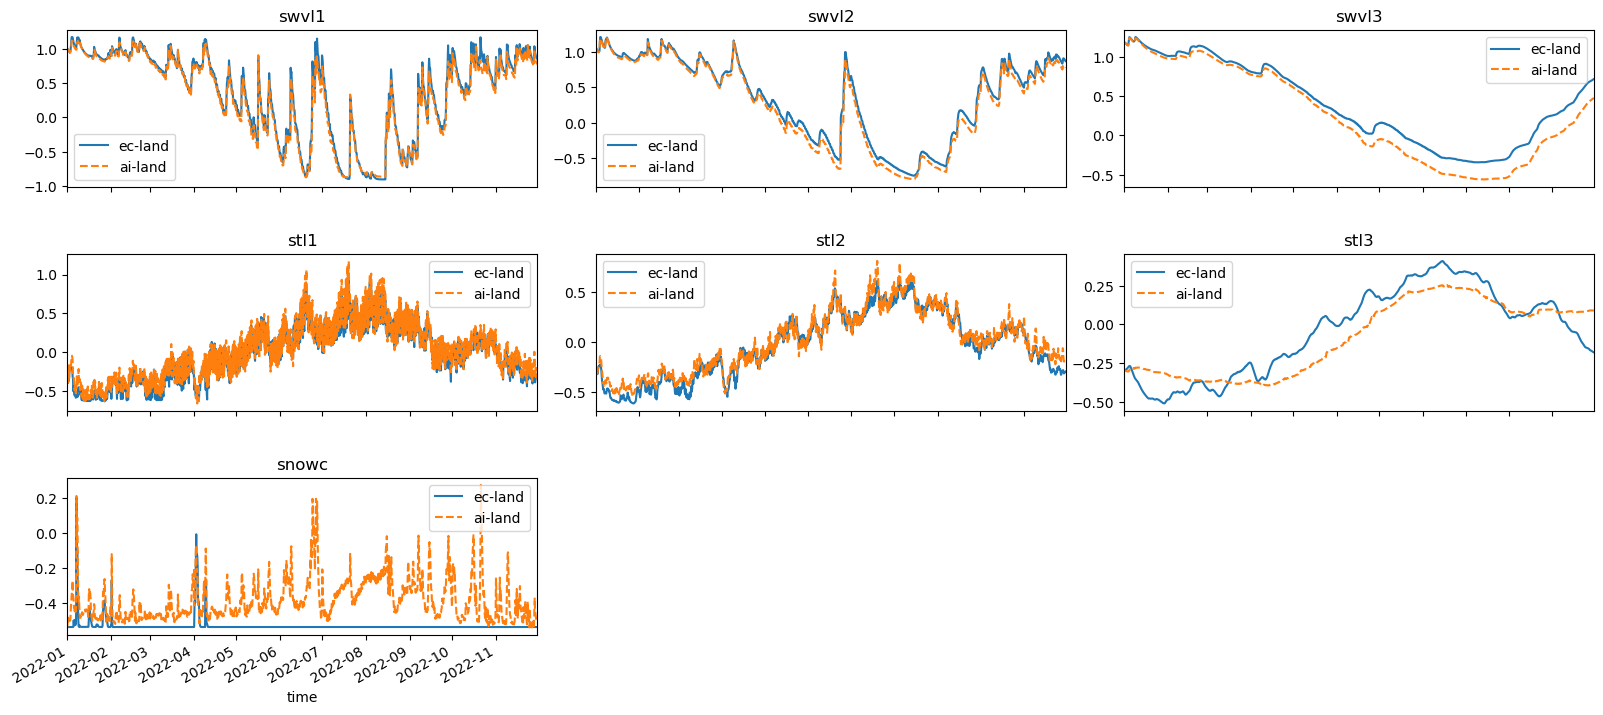

In [8]:
%%time
plot_class = tc.PlotCallback(2, dataset)
plot_class.make_subplot(model_pyt, 2)

In [ ]:
%%time
with torch.no_grad():
    preds, preds_diag = model_pyt.predict_step(clim, met, state, diagnostic)

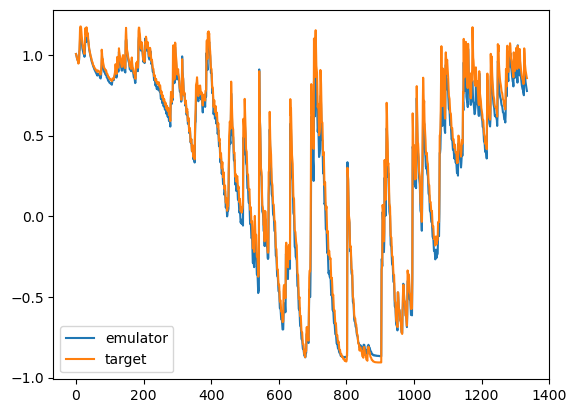

In [11]:
idx = 0
ll_idx = 500
plt.plot(preds[:, ll_idx, idx].detach().numpy(), label="emulator")
plt.plot(state[:, ll_idx, idx].detach().numpy(), label="target")
plt.legend()

In [ ]:
ds

In [2]:
x_idxs=[0, "None"]
#x_idxs=2
x = (0, None) if "None" in x_idxs else x_idxsdata_module

In [3]:
x

(0, None)

In [3]:
%%time
ds = zarr.open("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")

# Convert the list of hours to a pandas Series
hours_series = pd.Series(ds["time"])
# Create a datetime index starting from 2010-01-01
start_date = pd.to_datetime(dict(ds["time"].attrs)["units"][-10:])
date_times = start_date + pd.to_timedelta(hours_series, unit='h')
date_times

CPU times: user 14.5 ms, sys: 72.9 ms, total: 87.4 ms
Wall time: 4.28 s


0       2010-02-01 00:00:00
1       2010-02-01 06:00:00
2       2010-02-01 12:00:00
3       2010-02-01 18:00:00
4       2010-02-02 00:00:00
                ...        
18739   2022-11-29 18:00:00
18740   2022-11-30 00:00:00
18741   2022-11-30 06:00:00
18742   2022-11-30 12:00:00
18743   2022-11-30 18:00:00
Length: 18744, dtype: datetime64[ns]

In [14]:
list(ds)

['clim_data',
 'clim_means',
 'clim_stdevs',
 'clim_variable',
 'data',
 'data_means',
 'data_stdevs',
 'firstdiff_means',
 'firstdiff_stdevs',
 'lat',
 'lon',
 'time',
 'variable',
 'x']

In [63]:
start_index = min(np.argwhere(date_times.dt.year==int(CONFIG["start_year"])))
end_index = max(np.argwhere(date_times.dt.year==int(CONFIG["end_year"])))
len_dataset = end_index - start_index
print(start_index, end_index, len_dataset)

[8640] [17407] [8767]


In [94]:
x_idxs=(0, 10 + 4 +1)
ds.x[slice(0, 10 + 4 +1)]

array([2192, 2193, 2194, 2195, 2326, 2327, 2328, 2329, 2330, 2331, 2464,
       2465, 2466, 2467, 2468], dtype=int32)

In [79]:
%%time
clim_index = [list(ds["clim_variable"]).index(x) for x in CONFIG["clim_feats"]]
clim_index

CPU times: user 8.21 ms, sys: 3.49 ms, total: 11.7 ms
Wall time: 22 ms


[10, 9, 12, 0, 13, 11, 3, 2, 1, 8, 7, 15, 14, 19, 18, 21, 20, 17, 16]

In [65]:
ds["clim_data"].shape

(187070, 22)

In [12]:
%%time
ds = zarr.open("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
ds["data"][0]

CPU times: user 43.5 ms, sys: 83.9 ms, total: 127 ms
Wall time: 70.4 ms


array([[0.0000000e+00, 1.8028931e+02, 9.6036438e+04, ..., 2.5036263e+02,
        8.6097600e+05, 5.1504000e+04],
       [0.0000000e+00, 1.7871770e+02, 9.6024961e+04, ..., 2.4987630e+02,
        1.0522600e+06, 6.7132000e+04],
       [0.0000000e+00, 1.7103931e+02, 9.8091852e+04, ..., 2.4932454e+02,
        1.0861920e+06, 5.8864000e+04],
       ...,
       [0.0000000e+00, 1.6743513e+02, 6.9658438e+04, ..., 2.3532845e+02,
        6.2912800e+05, 4.7124000e+04],
       [0.0000000e+00, 1.7016040e+02, 6.9632406e+04, ..., 2.3547591e+02,
        6.6218000e+05, 5.0508000e+04],
       [0.0000000e+00, 1.7058357e+02, 6.9566375e+04, ..., 2.3554622e+02,
        7.1256000e+05, 5.5300000e+04]], dtype=float32)

In [15]:
%%time
ds = xr.open_zarr("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
#ds.data_vars
ds.data.data[0]

CPU times: user 18.8 ms, sys: 24.7 ms, total: 43.4 ms
Wall time: 284 ms


dask.array<getitem, shape=(187070, 30), dtype=float32, chunksize=(187070, 30), chunktype=numpy.ndarray>

In [16]:
def reset_chunk_encoding(da: xr.Dataset) -> xr.Dataset:
    """resets previous chunk encoding on concatenated zarr stores

    :param da: Dataset
    :return: Dataset with reset chunk encoding
    """
    for x in da.coords:
        if "chunks" in da[x].encoding.keys():
            #logging.info(f"deleting chunk encoding for {x}...")
            del da[x].encoding["chunks"]
        if da.coords[x].dtype == object:
            da[x].encoding.clear()

    for var in da:
        if "chunks" in da[var].encoding.keys():
            #logging.info(f"deleting chunk encoding for {var}...")
            del da[var].encoding["chunks"]
        if da[x].dtype == object:
            da[x].encoding.clear()
    return da


ds = reset_chunk_encoding(ds.isel(x=slice(38582-500, 38582+500)))
# ds.to_zarr("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")

In [19]:
list(ds.variable.values)

['met_ctpf',
 'met_lwdown',
 'met_psurf',
 'met_qair',
 'met_rainf',
 'met_swdown',
 'met_snowf',
 'met_tair',
 'met_wind_e',
 'met_wind_n',
 'lai_hv',
 'lai_lv',
 'd2m',
 'dis',
 'rsn',
 'sd',
 'skt',
 'snowc',
 'sro',
 'ssro',
 'stl1',
 'stl2',
 'stl3',
 'swvl1',
 'swvl2',
 'swvl3',
 't2m',
 'tsn',
 'sshf',
 'slhf']

In [31]:
%%time
VAR="met_snowf"

ds = zarr.open("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
latlon_idx = find_nearest_idx(ds["lat"][:], ds["lon"][:], 48, 5)
latlon_idx

# Convert the list of hours to a pandas Series
hours_series = pd.Series(ds["time"])
# Create a datetime index starting from 2010-01-01
start_date = pd.to_datetime(dict(ds["time"].attrs)["units"][-10:])
date_times = start_date + pd.to_timedelta(hours_series, unit='h')
start_index = min(np.argwhere(date_times.dt.year==2016))[0]
end_index = max(np.argwhere(date_times.dt.year==2022))[0]
len_dataset = end_index - start_index
print(start_index, end_index, len_dataset)

print(latlon_idx, ds["lat"][latlon_idx], ds["lon"][latlon_idx])
dat_arr = ds["data"][0+start_index:200+start_index, latlon_idx, list(ds["variable"]).index(VAR)]
# dat_arr = ds["data"][:, latlon_idx, list(ds["variable"]).index(VAR)]

8640 18743 10103
38582 48.007484 5.183246
CPU times: user 1.66 s, sys: 4.11 s, total: 5.77 s
Wall time: 2.93 s


In [27]:
ds = xr.open_zarr("/perm/daep/ec_land_db_test/ecland_i6aj_2016_2022_europe.zarr")
latlon_idx = find_nearest_idx(ds["lat"][:], ds["lon"][:], 48, 5)
latlon_idx
print(ds["lat"].values[latlon_idx], ds["lon"].values[latlon_idx])
dat_xr = ds[VAR].values[0:200, latlon_idx]

48.007484 5.183243


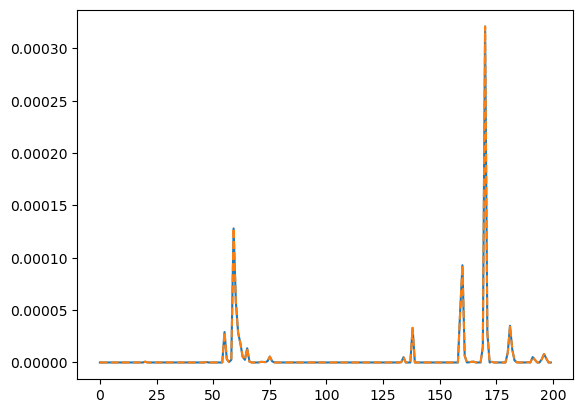

In [28]:
plt.plot(dat_arr)
plt.plot(dat_xr, '--')